# RSL-RL Performance Analysis
This notebook provides a comprehensive analysis of RSL-RL training performance across different quadruped robot platforms and terrain conditions.

## 1. Setup and Imports


In [54]:
# Import libraries and utilities
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
from scipy.stats import ttest_ind, mannwhitneyu

# Project root
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()

# Add analysis scripts directory to sys.path
ANALYSIS_DIR = PROJECT_ROOT / "scripts" / "analysis"
sys.path.insert(0, str(ANALYSIS_DIR))

# Import (and optionally reload) analysis utilities
import rsl_rl_analysis_utils as _rsl_utils_mod
importlib.reload(_rsl_utils_mod)

from rsl_rl_analysis_utils import (
    COMPARISONS, METRIC_PATTERNS, refresh_comparisons_with_latest,
    load_all_metrics, extract_key_metrics, find_metric_name,
    plot_comparison_bar, plot_training_curves, plot_multi_metric_bars,
    get_latest_checkpoint_value, get_metric_trajectory,
    compute_confidence_intervals, get_trajectory_data, compute_convergence_metrics,
    TENSORBOARD_AVAILABLE,
)

# Define directories
LOGS_DIR = PROJECT_ROOT / "logs" / "rsl_rl"
refresh_comparisons_with_latest(LOGS_DIR)
print("Using latest runs for each experiment in COMPARISONS")

print(f"Project root: {PROJECT_ROOT}")
print(f"Logs directory: {LOGS_DIR}")
print(f"TensorBoard available: {TENSORBOARD_AVAILABLE}")


Using latest runs for each experiment in COMPARISONS
Project root: /home/mahs/Development/project0/quadrrl
Logs directory: /home/mahs/Development/project0/quadrrl/logs/rsl_rl
TensorBoard available: True


## 2. Data Loading

Load training metrics from all TensorBoard log files for the runs defined in the comparison groups.


In [55]:
# Load all metrics
print("Loading metrics from TensorBoard logs...")
all_metrics = load_all_metrics(LOGS_DIR)

print(f"\nTotal runs loaded: {len(all_metrics)}")
print("\nLoaded runs:")
for run_key, run_data in all_metrics.items():
    num_metrics = len(run_data['metrics'])
    print(f"  - {run_data['display_name']}: {num_metrics} metrics")


Loading metrics from TensorBoard logs...

Total runs loaded: 8

Loaded runs:
  - Anymal-C Flat: 29 metrics
  - Anymal-C Rough: 30 metrics
  - Anymal-C Flat Direct: 24 metrics
  - Anymal-C Rough Direct: 24 metrics
  - Unitree Go2 Flat: 27 metrics
  - Unitree Go2 Rough: 28 metrics
  - Anymal-D Flat: 29 metrics
  - Anymal-D Rough: 30 metrics


In [43]:
# Extract key metrics into DataFrame
metrics_df = extract_key_metrics(all_metrics)

print(f"Metrics DataFrame shape: {metrics_df.shape}")
print(f"\nAvailable metric columns:")
metric_cols = [col for col in metrics_df.columns if col not in ['run_key', 'display_name', 'experiment', 'category']]
print(metric_cols)

# Show which metrics have data
print("\nMetrics with available data:")
for col in metric_cols:
    non_null = metrics_df[col].notna().sum()
    if non_null > 0:
        print(f"  {col}: {non_null}/{len(metrics_df)} runs have data")

# Display summary
display(metrics_df[['display_name', 'experiment', 'category'] + metric_cols[:5]].head())

# Save to CSV
    # metrics_csv = OUTPUT_DIR / "metrics_summary.csv"
    # metrics_df.to_csv(metrics_csv, index=False)
# print(f"\nMetrics summary saved to: {metrics_csv}")
  # Commented out



Metrics DataFrame shape: (8, 16)

Available metric columns:
['mean_reward', 'episode_length', 'policy_loss', 'value_loss', 'entropy', 'position_tracking', 'orientation_tracking', 'termination_penalty', 'base_contact', 'track_lin_vel', 'track_ang_vel', 'error_pos']

Metrics with available data:
  mean_reward: 8/8 runs have data
  episode_length: 8/8 runs have data
  policy_loss: 8/8 runs have data
  value_loss: 8/8 runs have data
  entropy: 8/8 runs have data
  base_contact: 8/8 runs have data
  track_lin_vel: 8/8 runs have data
  track_ang_vel: 8/8 runs have data


,display_name,experiment,category,mean_reward,episode_length,policy_loss,value_loss,entropy
0,Anymal-C Flat,anymal_c_flat,flat,39.311520,1000.000000,0.001298,0.003620,4.369410
1,Anymal-C Rough,anymal_c_rough,rough,31.838013,963.380005,0.000526,0.017668,10.747865
2,Anymal-C Flat Direct,anymal_c_flat_direct,flat_direct,26.867199,989.429993,-0.001066,0.000143,-15.480373
3,Anymal-C Rough Direct,anymal_c_rough_direct,rough_direct,17.071791,925.080017,-0.009624,0.006565,2.296700
4,Unitree Go2 Flat,unitree_go2_flat,flat,36.741768,996.169983,-0.003921,0.005639,2.606885


## 3. Performance Comparisons

### 3.1 Flat vs Rough Terrain Comparison

Compare performance on flat vs rough terrain across different robots and tasks.

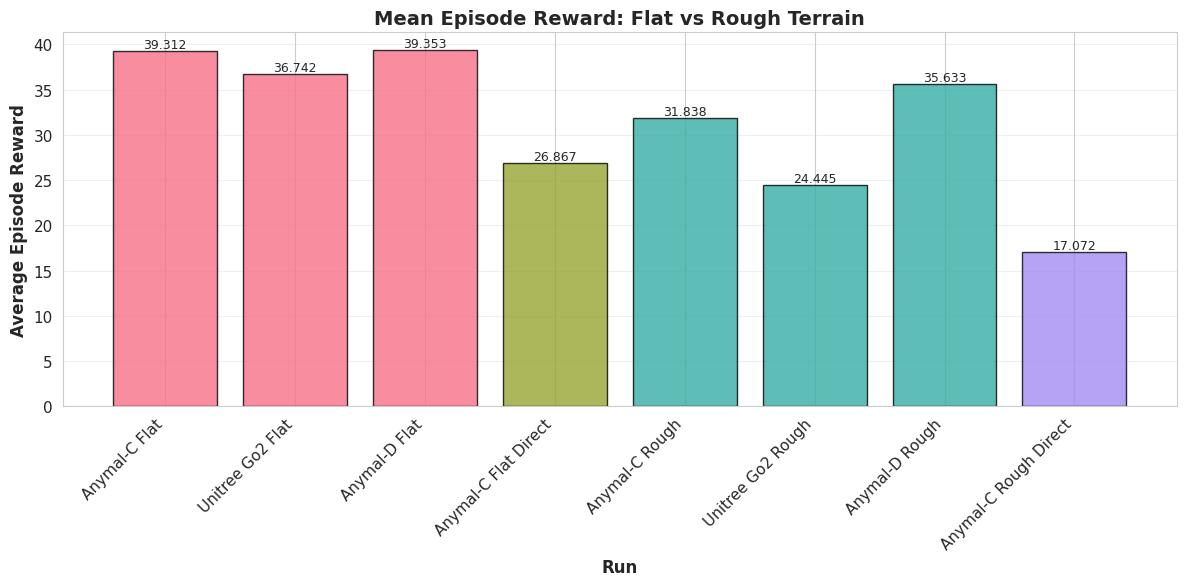

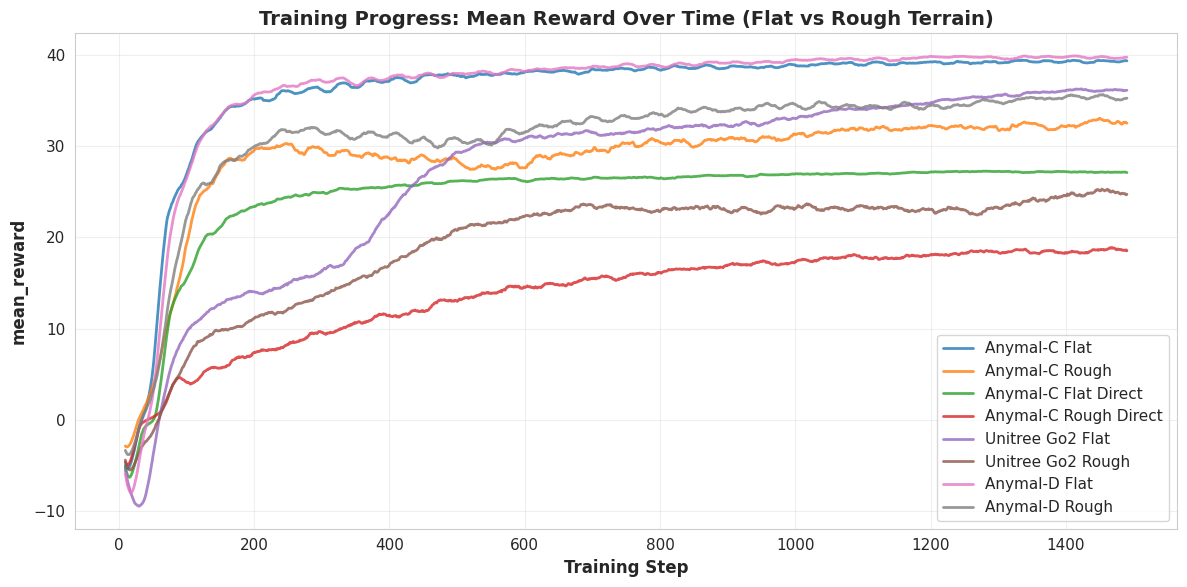

In [57]:
# Total reward comparison: Bar chart
metric_col = 'mean_reward'
if metric_col in metrics_df.columns:
    fig, ax = plt.subplots(figsize=(12, 6))
    plot_comparison_bar(
        metrics_df,
        'flat_vs_rough',
        metric_col,
        title='Mean Episode Reward: Flat vs Rough Terrain',
        ylabel='Average Episode Reward',
        ax=ax
    )
    plt.show()
else:
    print(f"Metric {metric_col} not available")

# Training curves: Mean reward over time
fig, ax = plt.subplots(figsize=(12, 6))
plot_training_curves(
    all_metrics,
    comparison_group='flat_vs_rough',
    metric_name='mean_reward',
    title='Training Progress: Mean Reward Over Time (Flat vs Rough Terrain)',
    smoothing=20,
    ax=ax,
)
plt.show()


STATISTICAL SUMMARY

Summary by Category:


mean_reward                       episode_length              \
                    mean        min        max           mean         min   
category                                                                    
flat           38.468829  36.741768  39.353199     995.949992  991.679993   
flat_direct    26.867199  26.867199  26.867199     989.429993  989.429993   
rough          30.638645  24.444668  35.633255     971.196655  962.359985   
rough_direct   17.071791  17.071791  17.071791     925.080017  925.080017   

                           
                      max  
category                   
flat          1000.000000  
flat_direct    989.429993  
rough          987.849976  
rough_direct   925.080017


Full Metrics Table (Latest Checkpoint Values):


,display_name,experiment,category,mean_reward,episode_length
6,Anymal-D Flat,anymal_d_flat,flat,39.353199,991.679993
0,Anymal-C Flat,anymal_c_flat,flat,39.311520,1000.000000
4,Unitree Go2 Flat,unitree_go2_flat,flat,36.741768,996.169983
7,Anymal-D Rough,anymal_d_rough,rough,35.633255,987.849976
1,Anymal-C Rough,anymal_c_rough,rough,31.838013,963.380005
2,Anymal-C Flat Direct,anymal_c_flat_direct,flat_direct,26.867199,989.429993
5,Unitree Go2 Rough,unitree_go2_rough,rough,24.444668,962.359985
3,Anymal-C Rough Direct,anymal_c_rough_direct,rough_direct,17.071791,925.080017


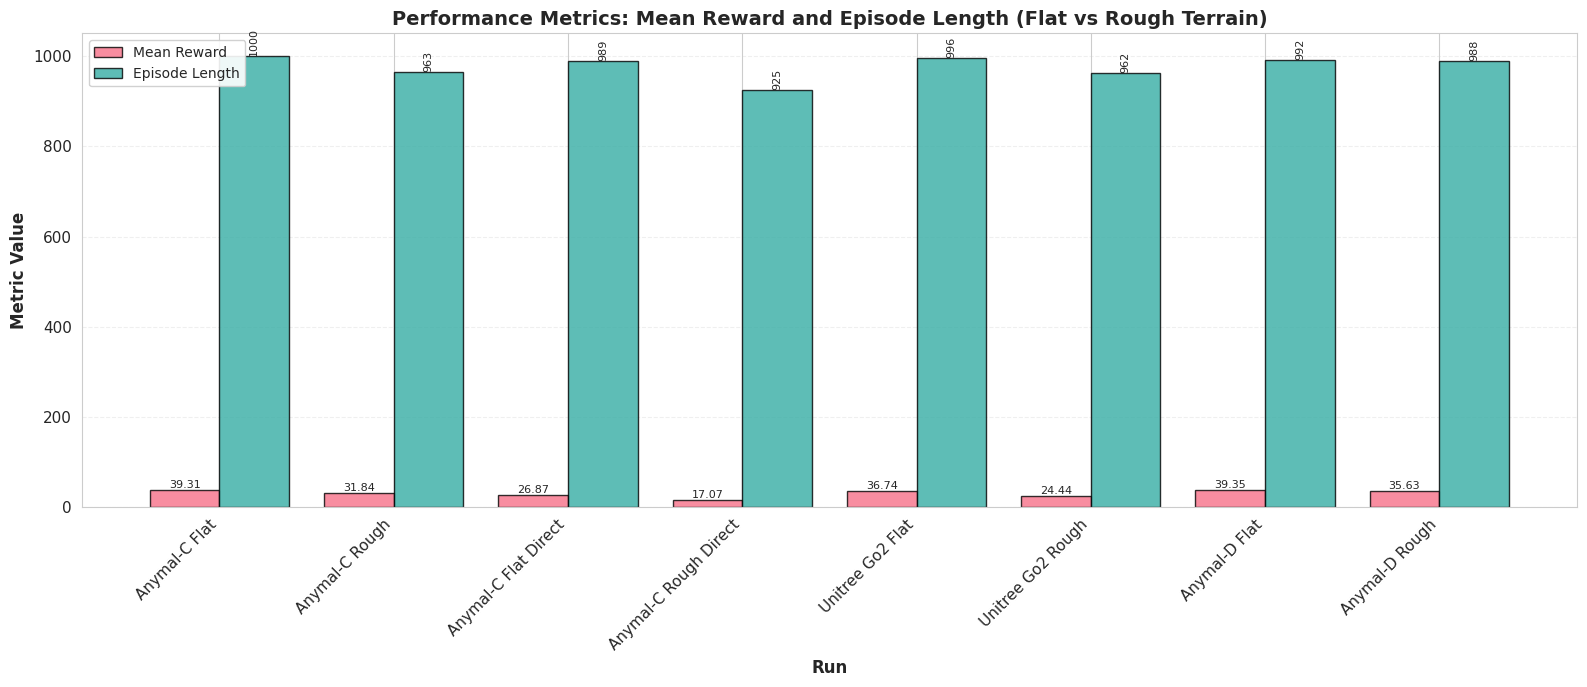

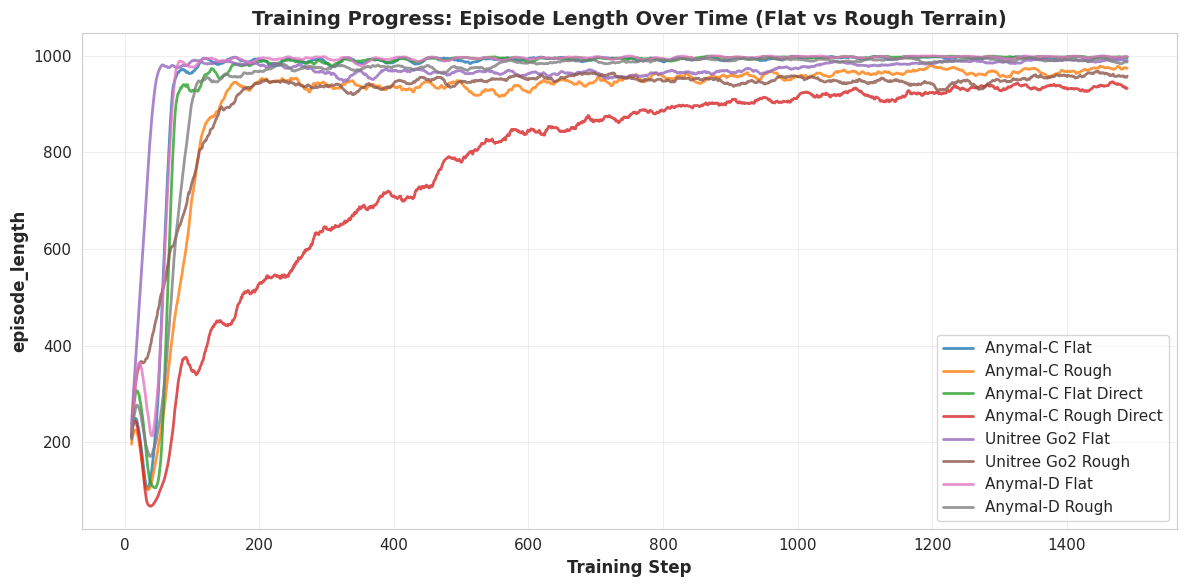

In [58]:
# Multi-metric comparison: Reward and Episode Length
metrics = ['mean_reward', 'episode_length']

print("="*80)
print("STATISTICAL SUMMARY")
print("="*80)

summary_cols = ['mean_reward', 'episode_length']
available_summary_cols = [c for c in summary_cols if c in metrics_df.columns]

if available_summary_cols:
    print("\nSummary by Category:")
    category_summary = metrics_df.groupby('category')[available_summary_cols].agg(['mean', 'min', 'max'])
    display(category_summary)
    
    # Full metrics table
    print("\nFull Metrics Table (Latest Checkpoint Values):")
    display_cols = ['display_name', 'experiment', 'category'] + available_summary_cols
    full_table = metrics_df[display_cols].sort_values(by='mean_reward', ascending=False)
    display(full_table)

# Filter to available metrics
available_metrics = [m for m in metrics if m in metrics_df.columns]

if len(available_metrics) >= 2:
    plot_multi_metric_bars(
        metrics_df,
        'flat_vs_rough',
        available_metrics,
        title='Performance Metrics: Mean Reward and Episode Length (Flat vs Rough Terrain)'
    )
    plt.show()
else:
    print(f'Not enough metrics. Available: {available_metrics}')

# Training curves: Episode length over time
fig, ax = plt.subplots(figsize=(12, 6))
plot_training_curves(
    all_metrics,
    comparison_group='flat_vs_rough',
    metric_name='episode_length',
    title='Training Progress: Episode Length Over Time (Flat vs Rough Terrain)',
    smoothing=20,
    ax=ax,
)
plt.show()


### 3.2 Direct vs Manager-based Control Comparison

DIRECT vs MANAGER-BASED CONTROL COMPREHENSIVE COMPARISON

Anymal-C: Direct vs Manager Comparison

Direct Control:


,display_name,category,mean_reward,episode_length,track_lin_vel,track_ang_vel
2,Anymal-C Flat Direct,flat_direct,26.867199,989.429993,0.968567,0.489486
3,Anymal-C Rough Direct,rough_direct,17.071791,925.080017,0.805047,0.419987



Manager-based Control:


,display_name,category,mean_reward,episode_length,track_lin_vel,track_ang_vel
0,Anymal-C Flat,flat,39.311520,1000.000000,1.896403,0.464103
1,Anymal-C Rough,rough,31.838013,963.380005,1.735787,0.409662



Statistical Comparison (Direct vs Manager):
  mean_reward (Flat): Direct=26.867, Manager=39.312, Diff=12.444 (46.3%)
  mean_reward (Rough): Direct=17.072, Manager=31.838, Diff=14.766 (86.5%)
  episode_length (Flat): Direct=989.430, Manager=1000.000, Diff=10.570 (1.1%)
  episode_length (Rough): Direct=925.080, Manager=963.380, Diff=38.300 (4.1%)
  track_lin_vel (Flat): Direct=0.969, Manager=1.896, Diff=0.928 (95.8%)
  track_lin_vel (Rough): Direct=0.805, Manager=1.736, Diff=0.931 (115.6%)
  track_ang_vel (Flat): Direct=0.489, Manager=0.464, Diff=-0.025 (-5.2%)
  track_ang_vel (Rough): Direct=0.420, Manager=0.410, Diff=-0.010 (-2.5%)


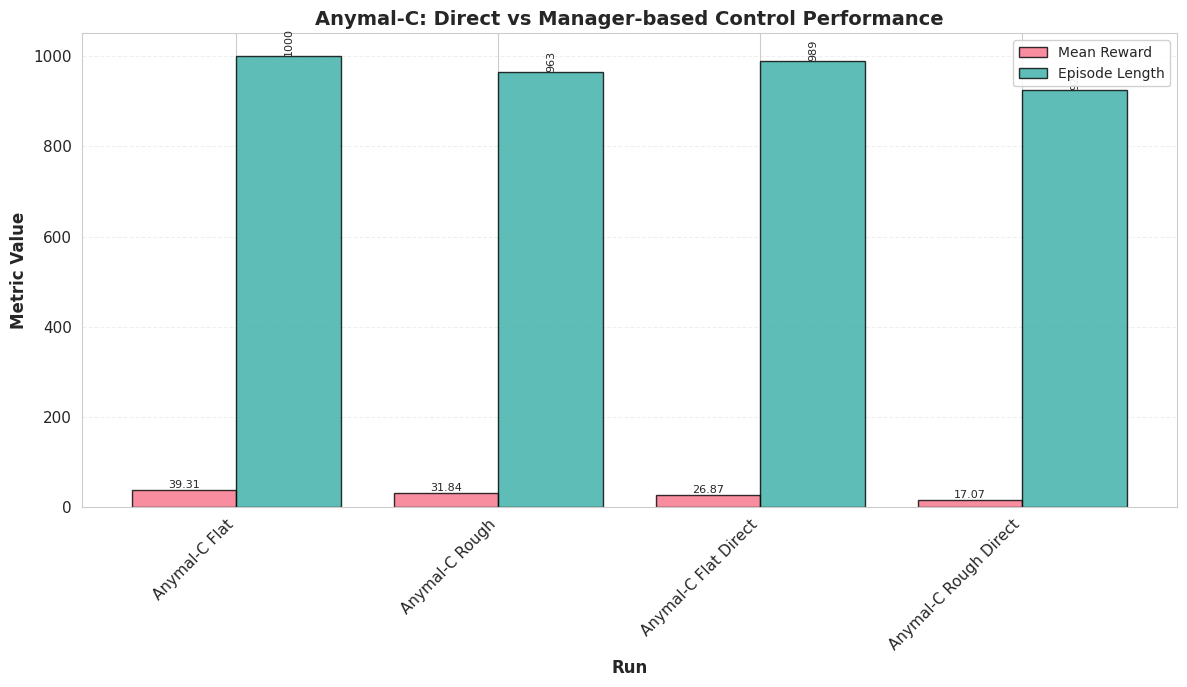

In [59]:
print("="*80)
print("DIRECT vs MANAGER-BASED CONTROL COMPREHENSIVE COMPARISON")
print("="*80)

# Filter to Anymal-C only (has both direct and manager)
anymal_c_data = metrics_df[metrics_df['experiment'].str.contains('anymal_c', case=False)].copy()

if not anymal_c_data.empty:
    print("\nAnymal-C: Direct vs Manager Comparison")
    
    # Compare metrics
    comparison_metrics = ['mean_reward', 'episode_length', 'track_lin_vel', 'track_ang_vel']
    available_comparison = [m for m in comparison_metrics if m in anymal_c_data.columns]
    
    if available_comparison:
        direct_data = anymal_c_data[anymal_c_data['experiment'].str.contains('direct', case=False)]
        manager_data = anymal_c_data[~anymal_c_data['experiment'].str.contains('direct', case=False)]
        
        print("\nDirect Control:")
        display(direct_data[['display_name', 'category'] + available_comparison])
        
        print("\nManager-based Control:")
        display(manager_data[['display_name', 'category'] + available_comparison])
        
        # Statistical comparison
        print("\nStatistical Comparison (Direct vs Manager):")
        for metric in available_comparison:
            direct_flat = direct_data[direct_data['category'].str.contains('flat', case=False, na=False)][metric].dropna()
            direct_rough = direct_data[direct_data['category'].str.contains('rough', case=False, na=False)][metric].dropna()
            manager_flat = manager_data[manager_data['category'].str.contains('flat', case=False, na=False)][metric].dropna()
            manager_rough = manager_data[manager_data['category'].str.contains('rough', case=False, na=False)][metric].dropna()
            
            if len(direct_flat) > 0 and len(manager_flat) > 0:
                flat_diff = manager_flat.iloc[0] - direct_flat.iloc[0] if len(direct_flat) > 0 and len(manager_flat) > 0 else np.nan
                flat_pct = (flat_diff / direct_flat.iloc[0] * 100.0) if direct_flat.iloc[0] != 0 and pd.notna(flat_diff) else np.nan
                print(f"  {metric} (Flat): Direct={direct_flat.iloc[0]:.3f}, Manager={manager_flat.iloc[0]:.3f}, "
                      f"Diff={flat_diff:.3f} ({flat_pct:.1f}%)")
            
            if len(direct_rough) > 0 and len(manager_rough) > 0:
                rough_diff = manager_rough.iloc[0] - direct_rough.iloc[0] if len(direct_rough) > 0 and len(manager_rough) > 0 else np.nan
                rough_pct = (rough_diff / direct_rough.iloc[0] * 100.0) if direct_rough.iloc[0] != 0 and pd.notna(rough_diff) else np.nan
                print(f"  {metric} (Rough): Direct={direct_rough.iloc[0]:.3f}, Manager={manager_rough.iloc[0]:.3f}, "
                      f"Diff={rough_diff:.3f} ({rough_pct:.1f}%)")
        
        # Plot comparison
        if len(available_comparison) >= 2:
            plot_multi_metric_bars(
                anymal_c_data,
                'direct_vs_manager',
                available_comparison[:2],  # Plot first 2 metrics
                title='Anymal-C: Direct vs Manager-based Control Performance'
            )
            plt.show()
else:
    print("Anymal-C data not available for comparison")


### 3.3 Velocity Tracking Accuracy Analysis


VELOCITY TRACKING ACCURACY ANALYSIS

Velocity Tracking Metrics:


,display_name,experiment,category,track_lin_vel,track_ang_vel
0,Anymal-C Flat,anymal_c_flat,flat,1.896403,0.464103
6,Anymal-D Flat,anymal_d_flat,flat,1.880688,0.459807
7,Anymal-D Rough,anymal_d_rough,rough,1.822826,0.426822
1,Anymal-C Rough,anymal_c_rough,rough,1.735787,0.409662
4,Unitree Go2 Flat,unitree_go2_flat,flat,1.411081,0.694955
5,Unitree Go2 Rough,unitree_go2_rough,rough,1.122982,0.607329
2,Anymal-C Flat Direct,anymal_c_flat_direct,flat_direct,0.968567,0.489486
3,Anymal-C Rough Direct,anymal_c_rough_direct,rough_direct,0.805047,0.419987



Velocity Tracking: Flat vs Rough Comparison
  track_lin_vel: Flat=1.539, Rough=1.372 (10.9% drop)
  track_ang_vel: Flat=0.527, Rough=0.466 (11.6% drop)


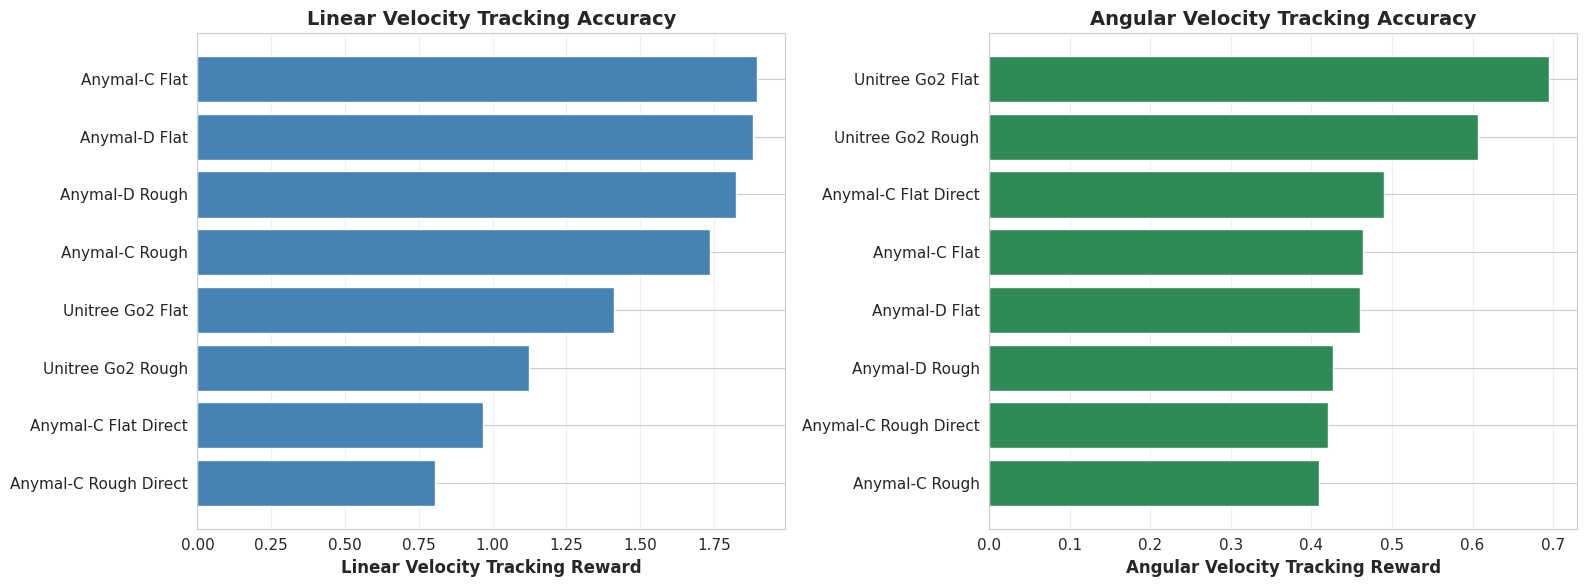

In [60]:
print("="*80)
print("VELOCITY TRACKING ACCURACY ANALYSIS")
print("="*80)

# Extract velocity tracking metrics
tracking_cols = ['track_lin_vel', 'track_ang_vel']
available_tracking = [col for col in tracking_cols if col in metrics_df.columns]

if available_tracking:
    tracking_df = metrics_df[['display_name', 'experiment', 'category'] + available_tracking].copy()
    
    print("\nVelocity Tracking Metrics:")
    display(tracking_df.sort_values('track_lin_vel', ascending=False, na_position='last'))
    
    if len(available_tracking) >= 1:
        flat_tracking = tracking_df[tracking_df['category'].str.contains('flat', case=False, na=False)]
        rough_tracking = tracking_df[tracking_df['category'].str.contains('rough', case=False, na=False)]
        
        if not flat_tracking.empty and not rough_tracking.empty:
            print("\nVelocity Tracking: Flat vs Rough Comparison")
            for col in available_tracking:
                flat_mean = flat_tracking[col].mean()
                rough_mean = rough_tracking[col].mean()
                if pd.notna(flat_mean) and pd.notna(rough_mean):
                    drop_pct = (flat_mean - rough_mean) / flat_mean * 100.0 if flat_mean != 0 else 0
                    print(f"  {col}: Flat={flat_mean:.3f}, Rough={rough_mean:.3f} ({drop_pct:.1f}% drop)")
                    
    # Plot velocity tracking comparison
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    if 'track_lin_vel' in available_tracking:
        valid_lin = tracking_df.dropna(subset=['track_lin_vel']).sort_values('track_lin_vel', ascending=False)
        if not valid_lin.empty:
            axes[0].barh(valid_lin['display_name'], valid_lin['track_lin_vel'], color='steelblue')
            axes[0].set_xlabel('Linear Velocity Tracking Reward', fontsize=12, fontweight='bold')
            axes[0].set_title('Linear Velocity Tracking Accuracy', fontsize=14, fontweight='bold')
            axes[0].grid(axis='x', alpha=0.3)
            axes[0].invert_yaxis()
    
    if 'track_ang_vel' in available_tracking:
        valid_ang = tracking_df.dropna(subset=['track_ang_vel']).sort_values('track_ang_vel', ascending=False)
        if not valid_ang.empty:
            axes[1].barh(valid_ang['display_name'], valid_ang['track_ang_vel'], color='seagreen')
            axes[1].set_xlabel('Angular Velocity Tracking Reward', fontsize=12, fontweight='bold')
            axes[1].set_title('Angular Velocity Tracking Accuracy', fontsize=14, fontweight='bold')
            axes[1].grid(axis='x', alpha=0.3)
            axes[1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    
else:
    print("Velocity tracking metrics not available")


### 3.4 Policy and Value Loss Analysis


POLICY AND VALUE LOSS

Final Loss Values:


,display_name,policy_loss,value_loss,total_loss
3,Anymal-C Rough Direct,-0.009624,0.006565,-0.003059
2,Anymal-C Flat Direct,-0.001066,0.000143,-0.000923
4,Unitree Go2 Flat,-0.003921,0.005639,0.001719
0,Anymal-C Flat,0.001298,0.003620,0.004919
6,Anymal-D Flat,0.003620,0.003770,0.007390
5,Unitree Go2 Rough,-0.009286,0.022516,0.013230
7,Anymal-D Rough,0.000258,0.014131,0.014389
1,Anymal-C Rough,0.000526,0.017668,0.018194


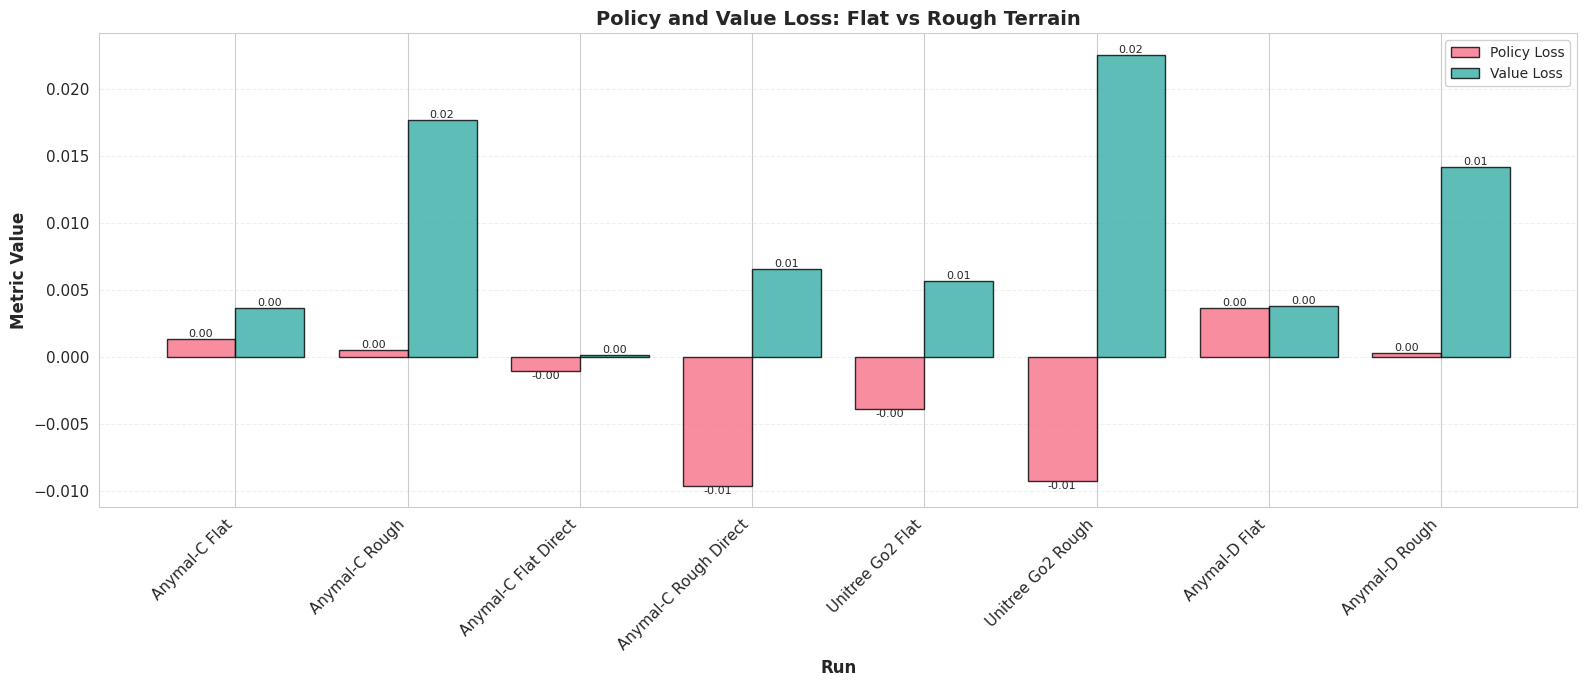

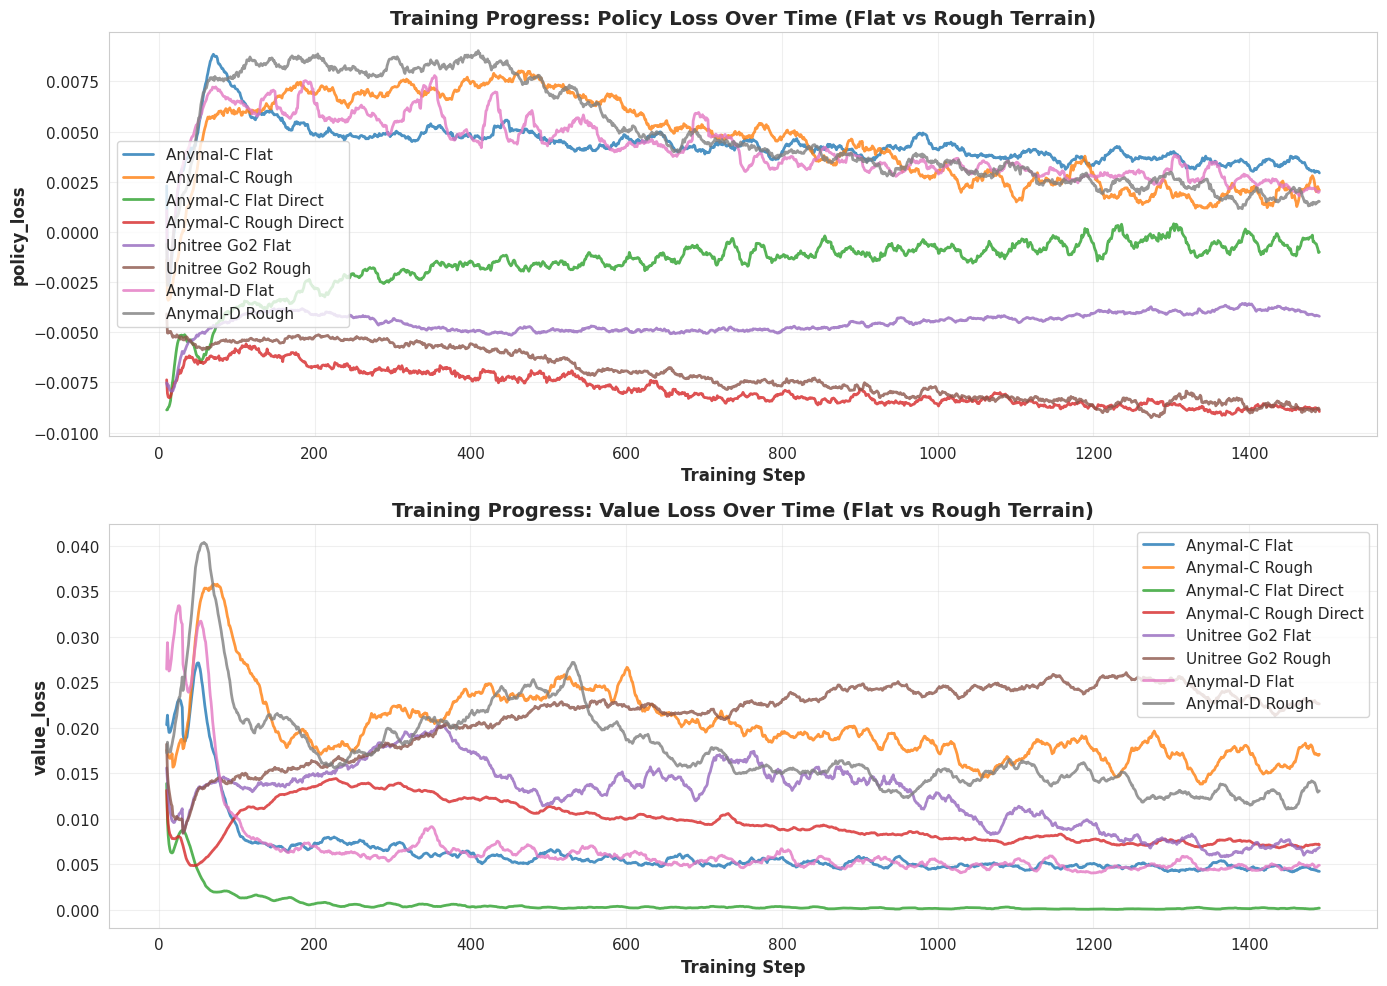

In [61]:
metrics = ['policy_loss', 'value_loss']

# Filter to available metrics
available_metrics = [m for m in metrics if m in metrics_df.columns]

print("="*80)
print("POLICY AND VALUE LOSS")
print("="*80)

# Loss statistics
loss_stats = []
for run_key, run_data in all_metrics.items():
    metrics = run_data['metrics']
    
    policy_tag = find_metric_name(metrics, METRIC_PATTERNS.get('policy_loss', ['policy_loss']))
    value_tag = find_metric_name(metrics, METRIC_PATTERNS.get('value_loss', ['value_loss']))
    
    policy_loss = get_latest_checkpoint_value(metrics, policy_tag) if policy_tag else None
    value_loss = get_latest_checkpoint_value(metrics, value_tag) if value_tag else None
    
    if policy_loss is not None or value_loss is not None:
        loss_stats.append({
            'display_name': run_data['display_name'],
            'policy_loss': policy_loss,
            'value_loss': value_loss,
            'total_loss': (policy_loss if policy_loss else 0) + (value_loss if value_loss else 0)
        })

if loss_stats:
    loss_df = pd.DataFrame(loss_stats)
    print("\nFinal Loss Values:")
    display(loss_df.sort_values('total_loss'))


# Multi-metric comparison: Policy and Value Loss
if len(available_metrics) >= 2:
    plot_multi_metric_bars(
        metrics_df,
        'flat_vs_rough',
        available_metrics,
        title='Policy and Value Loss: Flat vs Rough Terrain'
    )
    plt.show()
else:
    print(f'Not enough metrics. Available: {available_metrics}')

# Plot loss trends over training
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Policy loss trends
plot_training_curves(
    all_metrics,
    comparison_group='flat_vs_rough',
    metric_name='policy_loss',
    title='Training Progress: Policy Loss Over Time (Flat vs Rough Terrain)',
    smoothing=20,
    ax=axes[0],
)

# Value loss trends
plot_training_curves(
    all_metrics,
    comparison_group='flat_vs_rough',
    metric_name='value_loss',
    title='Training Progress: Value Loss Over Time (Flat vs Rough Terrain)',
    smoothing=20,
    ax=axes[1],
)

plt.tight_layout()
plt.show()


## 4. Flat vs Rough Terrain Statistical Tests


In [67]:
# Compute confidence intervals for mean_reward
ci_df = compute_confidence_intervals(all_metrics, 'mean_reward', window_size=100)

if not ci_df.empty:
    print("Confidence Intervals (95%) for Mean Reward (last 100 steps):")
    display(ci_df[['display_name', 'mean', 'ci_lower', 'ci_upper', 'std']])
    
    # Merge with metrics_df for plotting
    metrics_df_with_ci = metrics_df.merge(
        ci_df[['run_key', 'ci_lower', 'ci_upper', 'std']], 
        on='run_key', 
        how='left'
    )
else:
    metrics_df_with_ci = metrics_df.copy()
    print("Could not compute confidence intervals (insufficient data)")

Confidence Intervals (95%) for Mean Reward (last 100 steps):


,display_name,mean,ci_lower,ci_upper,std
0,Anymal-C Flat,39.356373,39.298835,39.413911,0.289979
1,Anymal-C Rough,32.593086,32.454871,32.731302,0.696575
2,Anymal-C Flat Direct,27.165607,27.134822,27.196392,0.155151
3,Anymal-C Rough Direct,18.558363,18.434613,18.682112,0.623670
4,Unitree Go2 Flat,36.172302,36.104938,36.239666,0.339500
5,Unitree Go2 Rough,24.908161,24.739314,25.077009,0.850953
6,Anymal-D Flat,39.790008,39.743527,39.836489,0.234255
7,Anymal-D Rough,35.406983,35.312244,35.501723,0.477466


In [68]:
# Test each robot: Flat vs Rough
robots_to_test = ['anymal_c', 'anymal_d', 'unitree_go2']
test_results = []

for robot in robots_to_test:
    flat_key = None
    rough_key = None
    
    # Find run keys
    for run_key, run_data in all_metrics.items():
        exp = run_data['experiment']
        if robot in exp.lower():
            if 'flat' in run_data['category'].lower() and 'direct' not in exp.lower():
                flat_key = run_key
            elif 'rough' in run_data['category'].lower() and 'direct' not in exp.lower():
                rough_key = run_key
    
    if flat_key and rough_key:
        flat_data = get_trajectory_data(all_metrics, flat_key, 'mean_reward', 100)
        rough_data = get_trajectory_data(all_metrics, rough_key, 'mean_reward', 100)
        
        if flat_data is not None and rough_data is not None and len(flat_data) > 0 and len(rough_data) > 0:
            # T-test (assumes normal distribution)
            t_stat, t_pvalue = ttest_ind(flat_data, rough_data)
            
            # Mann-Whitney U test (non-parametric, doesn't assume normality)
            u_stat, u_pvalue = mannwhitneyu(flat_data, rough_data, alternative='two-sided')
            
            # Effect size (Cohen's d)
            pooled_std = np.sqrt((np.var(flat_data) + np.var(rough_data)) / 2)
            cohens_d = (np.mean(flat_data) - np.mean(rough_data)) / pooled_std if pooled_std > 0 else 0
            
            test_results.append({
                'robot': robot.replace('_', '-').title(),
                'flat_mean': np.mean(flat_data),
                'rough_mean': np.mean(rough_data),
                'difference': np.mean(flat_data) - np.mean(rough_data),
                't_test_pvalue': t_pvalue,
                'mannwhitney_pvalue': u_pvalue,
                'cohens_d': cohens_d,
                'significant_ttest': t_pvalue < 0.05,
                'significant_mannwhitney': u_pvalue < 0.05
            })

if test_results:
    test_df = pd.DataFrame(test_results)
    print("\nStatistical Test Results:")
    display(test_df)
    
    print("\nInterpretation:")
    print("  - t_test_pvalue: p-value from independent t-test (assumes normality)")
    print("  - mannwhitney_pvalue: p-value from Mann-Whitney U test (non-parametric)")
    print("  - cohens_d: Effect size (|d| < 0.2: small, 0.2-0.5: medium, >0.5: large)")
    print("  - significant_*: True if p < 0.05")
else:
    print("Could not perform statistical tests (insufficient trajectory data)")



Statistical Test Results:


,robot,flat_mean,rough_mean,difference,t_test_pvalue,mannwhitney_pvalue,cohens_d,significant_ttest,significant_mannwhitney
0,Anymal-C,39.356373,32.593086,6.763286,3.085606e-162,2.562144e-34,12.740394,True,True
1,Anymal-D,39.790008,35.406983,4.383024,3.359955e-155,2.562144e-34,11.713690,True,True
2,Unitree-Go2,36.172302,24.908161,11.264141,6.337889e-189,2.562144e-34,17.474944,True,True



Interpretation:
  - t_test_pvalue: p-value from independent t-test (assumes normality)
  - mannwhitney_pvalue: p-value from Mann-Whitney U test (non-parametric)
  - cohens_d: Effect size (|d| < 0.2: small, 0.2-0.5: medium, >0.5: large)
  - significant_*: True if p < 0.05


## 5. Training Convergence Rate Analysis

Analyze how fast each policy improves during training.


Convergence Rate Metrics:


,display_name,overall_slope,steps_to_50pct,steps_to_75pct,steps_to_90pct,total_improvement
4,Unitree Go2 Flat,0.021340,318,452,832,37.276737
5,Unitree Go2 Rough,0.013090,192,408,502,24.999592
6,Anymal-D Flat,0.011167,73,111,193,39.665970
3,Anymal-C Rough Direct,0.011050,174,390,560,17.751876
7,Anymal-D Rough,0.010944,81,118,236,35.911418
0,Anymal-C Flat,0.010286,63,108,193,39.720547
1,Anymal-C Rough,0.009530,89,113,153,32.139080
2,Anymal-C Flat Direct,0.008457,83,122,215,27.486626


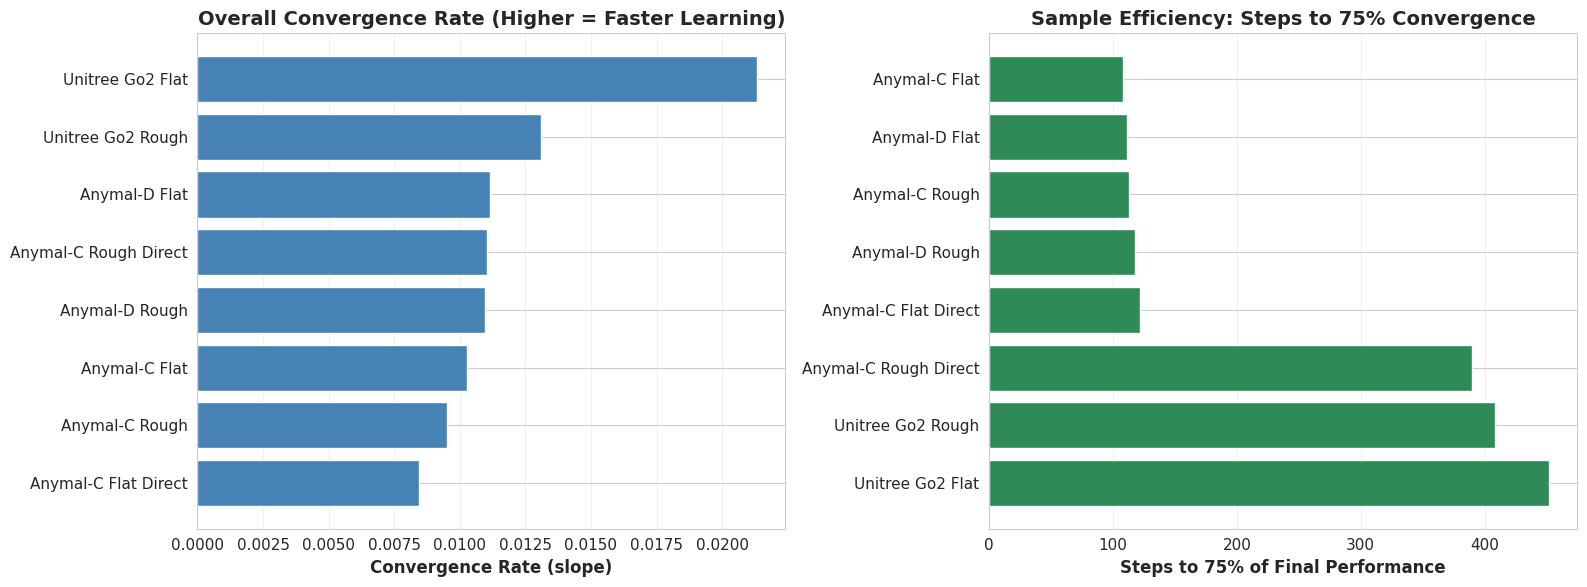

In [ ]:
convergence_df = compute_convergence_metrics(all_metrics, 'mean_reward')

if not convergence_df.empty:
    print("Convergence Rate Metrics:")
    display_cols = ['display_name', 'overall_slope', 'steps_to_50pct', 'steps_to_75pct', 
                    'steps_to_90pct', 'total_improvement']
    display(convergence_df[display_cols].sort_values('overall_slope', ascending=False))
    
    # Plot convergence rates
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Overall slope comparison
    valid_slopes = convergence_df.dropna(subset=['overall_slope']).sort_values('overall_slope', ascending=False)
    if not valid_slopes.empty:
        axes[0].barh(valid_slopes['display_name'], valid_slopes['overall_slope'], color='steelblue')
        axes[0].set_xlabel('Convergence Rate (slope)', fontsize=12, fontweight='bold')
        axes[0].set_title('Overall Convergence Rate (Higher = Faster Learning)', fontsize=14, fontweight='bold')
        axes[0].grid(axis='x', alpha=0.3)
        axes[0].invert_yaxis()
    
    # Steps to 75% of final performance (normalized metric)
    valid_steps = convergence_df.dropna(subset=['steps_to_75pct']).sort_values('steps_to_75pct')
    if not valid_steps.empty:
        axes[1].barh(valid_steps['display_name'], valid_steps['steps_to_75pct'], color='seagreen')
        axes[1].set_xlabel('Steps to 75% of Final Performance', fontsize=12, fontweight='bold')
        axes[1].set_title('Sample Efficiency: Steps to 75% Convergence', fontsize=14, fontweight='bold')
        axes[1].grid(axis='x', alpha=0.3)
        axes[1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()
else:
    print("Could not compute convergence metrics")


## 6. Summary and Key Insights


In [63]:
print("="*80)
print("KEY INSIGHTS AND FINDINGS")
print("="*80)

insights = []
# Convenience: flat/rough split per robot from metrics_df
summary_cols = ["mean_reward", "episode_length"]
robots = ["Anymal-C", "Anymal-D", "Unitree Go2"]

# Map display names in metrics_df to a simple robot key and terrain
def parse_name(name: str):
    # Assumes names like "Anymal-C Flat", "Unitree Go2 Rough"
    parts = name.split()
    robot = " ".join(parts[:-1])   # all but last
    terrain = parts[-1].lower()    # "Flat"/"Rough"
    return robot, terrain

robot_stats = {}
for _, row in metrics_df.iterrows():
    robot, terrain = parse_name(row["display_name"])
    if robot not in robots:
        continue
    key = (robot, terrain)
    robot_stats[key] = row

# 2. Statistical significance
if 'test_df' in globals() and not test_df.empty:
    significant_count = test_df['significant_mannwhitney'].sum()
    total_tests = len(test_df)
    insights.append({
        "Finding": "Statistical Significance",
        "Detail": (
            f"{significant_count}/{total_tests} robot comparisons show statistically significant "
            f"differences between flat and rough terrain (Mann-Whitney U test, p < 0.05)."
        )
    })

# 1. Terrain difficulty impact per robot
flat_means, rough_means = [], []
for robot in robots:
    flat_row = robot_stats.get((robot, "flat"))
    rough_row = robot_stats.get((robot, "rough"))
    if flat_row is None or rough_row is None:
        continue
    flat = flat_row["mean_reward"]
    rough = rough_row["mean_reward"]
    flat_means.append(flat)
    rough_means.append(rough)
    drop_pct = (flat - rough) / flat * 100.0 if flat != 0 else 0.0
    insights.append({
        "Finding": "Terrain Difficulty Impact",
        "Detail": (
            f"{robot}: rough terrain mean reward is {drop_pct:.1f}% lower than flat "
            f"({flat:.2f} → {rough:.2f})."
        ),
    })

overall_flat = np.mean(flat_means)
overall_rough = np.mean(rough_means)
overall_drop = (overall_flat - overall_rough) / overall_flat * 100.0
insights.insert(0, {
    "Finding": "Terrain Difficulty Impact (Overall)",
    "Detail": (
        f"Across robots, rough terrain reduces final mean reward by "
        f"{overall_drop:.1f}% on average "
        f"({overall_flat:.2f} → {overall_rough:.2f})."
    ),
})

# 2. Best performing policy (flat)
flat_only = metrics_df[metrics_df["category"] == "flat"]
if "mean_reward" in flat_only.columns and not flat_only.empty:
    best_flat = flat_only.loc[flat_only["mean_reward"].idxmax()]
    second_flat = flat_only.sort_values("mean_reward", ascending=False).iloc[1]
    gap_pct = (best_flat["mean_reward"] - second_flat["mean_reward"]) / second_flat["mean_reward"] * 100.0
    insights.append({
        "Finding": "Best Performing Policy (Flat Terrain)",
        "Detail": (
            f"{best_flat['display_name']} achieves the highest total reward "
            f"({best_flat['mean_reward']:.2f}), "
            f"about {gap_pct:.1f}% higher than {second_flat['display_name']}."
        ),
        "Experiment": best_flat["experiment"],
    })


# 4. Training stability
if "episode_length" in metrics_df.columns:
    stable_runs = metrics_df[metrics_df["episode_length"] >
                             metrics_df["episode_length"].quantile(0.75)]
    insights.append({
        "Finding": "Training Stability",
        "Detail": (
            f"{len(stable_runs)} policies show high episode stability "
            f"(top 25% episode lengths), including "
            f"{', '.join(stable_runs['display_name'].tolist())}."
        )
    })

# 3. Convergence rate insights
if 'convergence_df' in globals() and not convergence_df.empty:
    fastest = convergence_df.loc[convergence_df['overall_slope'].idxmax()]
    slowest = convergence_df.loc[convergence_df['overall_slope'].idxmin()]
    
    if pd.notna(fastest['overall_slope']) and pd.notna(slowest['overall_slope']):
        factor = fastest['overall_slope'] / slowest['overall_slope'] if slowest['overall_slope'] > 0 else np.inf
        insights.append({
            "Finding": "Convergence Rate",
            "Detail": (
                f"{fastest['display_name']} has the fastest convergence rate "
                f"(slope={fastest['overall_slope']:.6f}), "
                f"about {factor:.1f}× faster than {slowest['display_name']}."
            )
        })


# 5. Velocity tracking insights
tracking_data = metrics_df[['display_name', 'track_lin_vel', 'track_ang_vel']].dropna(subset=['track_lin_vel', 'track_ang_vel'])
if not tracking_data.empty:
    best_lin = tracking_data.loc[tracking_data['track_lin_vel'].idxmax()]
    best_ang = tracking_data.loc[tracking_data['track_ang_vel'].idxmax()]
    
    insights.append({
        "Finding": "Velocity Tracking Performance",
        "Detail": (
            f"Best linear velocity tracking: {best_lin['display_name']} ({best_lin['track_lin_vel']:.3f}). "
            f"Best angular velocity tracking: {best_ang['display_name']} ({best_ang['track_ang_vel']:.3f})."
        )
    })

# Print nicely
for i, ins in enumerate(insights, 1):
    print(f"\n{i}. {ins['Finding']}")
    print(f"   {ins['Detail']}")
    for k, v in ins.items():
        if k not in ["Finding", "Detail"]:
            print(f"   {k}: {v}")

KEY INSIGHTS AND FINDINGS

1. Terrain Difficulty Impact (Overall)
   Across robots, rough terrain reduces final mean reward by 20.4% on average (38.47 → 30.64).

2. Statistical Significance
   3/3 robot comparisons show statistically significant differences between flat and rough terrain (Mann-Whitney U test, p < 0.05).

3. Terrain Difficulty Impact
   Anymal-C: rough terrain mean reward is 19.0% lower than flat (39.31 → 31.84).

4. Terrain Difficulty Impact
   Anymal-D: rough terrain mean reward is 9.5% lower than flat (39.35 → 35.63).

5. Terrain Difficulty Impact
   Unitree Go2: rough terrain mean reward is 33.5% lower than flat (36.74 → 24.44).

6. Best Performing Policy (Flat Terrain)
   Anymal-D Flat achieves the highest total reward (39.35), about 0.1% higher than Anymal-C Flat.
   Experiment: anymal_d_flat

7. Training Stability
   2 policies show high episode stability (top 25% episode lengths), including Anymal-C Flat, Unitree Go2 Flat.

8. Convergence Rate
   Unitree Go2 Fla